## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import sys
sys.path.insert(1, './../src/')

import time 

import load_option_data_01 

from pathlib import Path

import bsm_pricer as bsm
import config
import datetime
import level_1_filters as f1
import level_2_filters as f2
import level_3_filters as f3
import load_option_data_01 
import load_option_data_01 as l1


import time 
import warnings
import wrds

In [2]:
import importlib

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [4]:
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

START_DATE_02 =config.START_DATE_02
END_DATE_02 = config.END_DATE_02

NOTE_START = START_DATE_01
NOTE_END = END_DATE_01

In [5]:
DATE_RANGE =f'{pd.Timestamp(START_DATE_01):%Y-%m}_{pd.Timestamp(END_DATE_02):%Y-%m}'

## Function Definitions

In [6]:
def compare_filtered_data_to_orig(filtered_df, orig_df, filter_name="Identical Filter"):
    print("|", filter_name,":")
    print(f'>> Records removed: {orig_df.shape[0]-filtered_df.shape[0]:,.0f} out of {orig_df.shape[0]:,.0f} ({(orig_df.shape[0]-filtered_df.shape[0])/orig_df.shape[0]:,.2%})')
    print(f'>> Filtered data shape: {filtered_df.shape[0]:,.0f} rows // {filtered_df.shape[1]:,.0f} columns')

In [7]:
def fit_and_store_curve(group):
    """
    Fit a quadratic curve to the given group of data points and store the fitted values.

    Args:
        group (pandas.DataFrame): The group of data points to fit the curve to.

    Returns:
        pandas.DataFrame: The group of data points with the fitted values stored in the 'fitted_iv' column.
    """
    try:
        # Fit the quadratic curve
        coefficients = np.polyfit(group['moneyness'], group['log_iv'], 2)
        # Calculate fitted values
        group['fitted_iv'] = np.polyval(coefficients, group['moneyness'])
    except np.RankWarning:
        print("Polyfit may be poorly conditioned")
    return group

In [8]:
def calc_relative_distance(series1, series2, method='percent'):
    """
    Calculate the relative distance between the implied volatility and the fitted implied volatility.
    
    Parameters:
        method (str): The method to calculate the relative distance. Options are 'percent', 'manhattan', or 'euclidean'.
        
    Returns:
        numpy.ndarray: The relative distance calculated based on the specified method.
        
    Raises:
        ValueError: If the method is not one of 'percent', 'manhattan', or 'euclidean'.
    """
    
    if method == 'percent':
        result = (series1 - series2) / series2 * 100
    elif method == 'manhattan':
        result = abs(series1 - series2)
    elif method == 'euclidean':
        result = np.sqrt((series1 - series2)**2)
    else:
        raise ValueError("Method must be 'percent', 'manhattan', or 'euclidean'")
    
    result = np.where(np.isinf(result), np.nan, result)
    
    return result

In [9]:
def mark_outliers(row, std_devs, outlier_threshold):
    """
    Determines if a data point is an outlier based on its moneyness_bin and relative distance from the fitted curve.
    
    Args:
        row (pandas.Series): A row of data containing the moneyness_bin and rel_distance columns.
        std_devs (pandas.DataFrame): A DataFrame containing the standard deviations for each moneyness_bin.
    
    Returns:
        bool: True if the data point is an outlier, False otherwise.
    """
    
    # Attempt to retrieve the standard deviation for the row's moneyness_bin
# This operation may be vectorizable if repeated across rows
    std_dev_row = std_devs.loc[std_devs['moneyness_bin'] == row['moneyness_bin'], 'std_dev']
    
    # Check if std_dev_row is empty (i.e., no matching moneyness_bin was found)
    if not std_dev_row.empty:
        std_dev = std_dev_row.values[0]
        # Calculate how many std_devs away from the fitted curve the IV is
        if abs(row['rel_distance']) > outlier_threshold * std_dev:  # Adjust this threshold as needed
            return True
    else:
        # Handle the case where no matching moneyness_bin was found
        return False
    return False


def build_put_call_pairs(call_options, put_options):
    """
    Builds pairs of call and put options based on the same date, expiration date, and moneyness.

    Args:
        call_options (DataFrame): DataFrame containing call options data.
        put_options (DataFrame): DataFrame containing put options data.

    Returns:
        tuple of (matching_calls: pd.DataFrame, matching_puts: pd.DataFrame)
    """
    call_options.set_index(['date', 'exdate', 'moneyness'], inplace=True)
    put_options.set_index(['date', 'exdate', 'moneyness'], inplace=True)
    
    # get common indices
    common_index = call_options.index.intersection(put_options.index)

    # Extract the matching entries
    matching_calls = call_options.loc[common_index]
    matching_puts = put_options.loc[common_index]
    
    result = (matching_calls, matching_puts)

    return result


def test_price_strike_match(matching_calls_puts):
    """
    Check if the strike prices and security prices of matching calls and puts are equal.

    Parameters:
    matching_calls_puts (DataFrame): DataFrame containing matching calls and puts data.

    Returns:
    bool: True if the strike prices and security prices of matching calls and puts are equal, False otherwise.
    """
    return (np.allclose(matching_calls_puts['strike_price_C'], matching_calls_puts['strike_price_P'])) and (np.allclose(matching_calls_puts['sec_price_C'], matching_calls_puts['sec_price_P']))# and (np.allclose(matching_calls_puts['tb_m3_C'], matching_calls_puts['tb_m3_P']))


def calc_implied_interest_rate(matched_options):
    """
    Calculates the implied interest rate based on the given matched options data.

    Parameters:
    matched_options (DataFrame): DataFrame containing the matched options data.

    Returns:
    DataFrame: DataFrame with an additional column 'pc_parity_int_rate' representing the implied interest rate.
    
    Raises:
    ValueError: If there is a mismatch between the price and strike price of the options.
    """
    
    # underlying price
    if test_price_strike_match(matched_options):
        print(">> Underlying prices, strike prices of put and call options match exactly.")
        S = matched_options['sec_price_C']
        K = matched_options['strike_price_C']  
        
        # 1/T = 1/time to expiration in years
        T_inv = np.power((matched_options.reset_index()['exdate']-matched_options.reset_index()['date'])/datetime.timedelta(days=365), -1)
        T_inv.index=matched_options.index
        T_inv
        
        C_mid = matched_options['mid_price_C']
        P_mid = matched_options['mid_price_P']
        # implied interest rate
        matched_options['pc_parity_int_rate'] = np.log((S-C_mid+P_mid)/K) * T_inv
        return matched_options
    else:
        raise ValueError("Price and strike price mismatch")


def pcp_filter_outliers(matched_options, int_rate_rel_distance_func, outlier_threshold):
    """
    Filters out outliers based on the relative distance of interest rates and the outlier threshold.

    Parameters:
    - matched_options (DataFrame): DataFrame containing the matched options data.
    - int_rate_rel_distance_func (str): Method to calculate the relative distance of interest rates.
    - outlier_threshold (float): Threshold for flagging outliers.

    Returns:
    - l3_filtered_options (DataFrame): DataFrame with outliers filtered out.

    """

    matched_options['rel_distance_int_rate'] = calc_relative_distance(matched_options['pc_parity_int_rate'], matched_options['daily_median_rate'], method=int_rate_rel_distance_func)
    # fill 3905 nans...
    matched_options['rel_distance_int_rate'] = matched_options['rel_distance_int_rate'].fillna(0.0)

    # calculate the standard deviation of the relative distances
    stdev_int_rate_rel_distance = matched_options['rel_distance_int_rate'].std()

    # flag outliers based on the threshold
    matched_options['is_outlier_int_rate'] = matched_options['rel_distance_int_rate'].abs() > outlier_threshold * stdev_int_rate_rel_distance

    # filter out the outliers
    l3_filtered_options = matched_options[~matched_options['is_outlier_int_rate']]

    # make the dataframe long-form to compare to the level 2 data
    _calls = l3_filtered_options.filter(like='_C').rename(columns=lambda x: x.replace('_C', ''))
    _puts = l3_filtered_options.filter(like='_P').rename(columns=lambda x: x.replace('_P', ''))
    l3_filtered_options = pd.concat((_calls, _puts), axis=0)

    # update the final results for this combination of relative distance method and outlier threshold
    return l3_filtered_options


def iv_filter_outliers(l2_data, iv_distance_method, iv_outlier_threshold):
    """
    Filter out outliers based on the relative distance of log_iv and fitted_iv.

    Parameters:
    l2_data (DataFrame): Input data containing log_iv, fitted_iv, moneyness columns.
    iv_distance_method (str): Method to calculate relative distance of log_iv and fitted_iv.
    iv_outlier_threshold (float): Threshold value to flag outliers.

    Returns:
    DataFrame: Filtered data without outliers.

    """
    l2_data['rel_distance_iv'] = calc_relative_distance(l2_data['log_iv'], l2_data['fitted_iv'], method=iv_distance_method)

    # Define moneyness bins
    bins = np.arange(0.8, 1.21, 0.05)
    l2_data['moneyness_bin'] = pd.cut(l2_data['moneyness'], bins=bins)

    # Compute standard deviation of relative distances within each moneyness bin
    std_devs = l2_data.groupby('moneyness_bin')['rel_distance_iv'].std().reset_index(name='std_dev')
    
    l2_data['stdev_iv_moneyness_bin'] = l2_data['moneyness_bin'].map(std_devs.set_index('moneyness_bin')['std_dev'])
    l2_data['stdev_iv_moneyness_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)
    # flag outliers based on the threshold
    l2_data['is_outlier_iv'] = l2_data['rel_distance_iv'].abs() > l2_data['stdev_iv_moneyness_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)

    # filter out the outliers
    l3_data_iv_only = l2_data[~l2_data['is_outlier_iv']]
    
    # update the final results for this combination of relative distance method and outlier threshold
    return l3_data_iv_only

## Data Note

- The original CJS 2013 paper used data from 1986 through 2012 (26 years of data).
- Due to the unavailability of SPX option data from 1985 to 1995, we replicated the **54 CJS portfolios** using data from **January 1996 to December 2019** (23 years).
- Our dataset (from 1996 to 2019) comprises over 19.2 million rows of SPX options data.
- The original effectiveness of the data filters was examined in *The Puzzle of Filtering Index Options (Desai, Hammock, Holt; 2024)*. Due to similar reasons as outlined in that work (loss of data filter elegance when transposed across timeframes), we expect that the data filter parameters (and thus the portfolios constructed) will not yield identical results to the original published work, and the user should not have this expectation. 

*The spirit of this project is to replicate with the highest practical fidelity the *process* of data filtration and portfolio construction in the original CJS and HKM papers, without commenting on the effectiveness or appropriateness of the process and parameters. We leave that analysis to a future study.*

In [10]:
file_path = Path(DATA_DIR / 'pulled/data_1996-01_2019-12.parquet')

if file_path.exists():
    print(">> File already exists. Loading data from file...")
    # Load the data from the file
    raw_option_data = pd.read_parquet(file_path)
else:
    print(">> File does not exist. Loading data from WRDS...")
    # Load the data from WRDS
    raw_option_data = pd.concat([
        pd.read_parquet(Path(DATA_DIR / 'pulled/data_1996-01_2012-01.parquet')),
        pd.read_parquet(Path(DATA_DIR / 'pulled/data_2012-02_2019-12.parquet'))
    ])
    raw_option_data.to_parquet(file_path)

# add the mid price
raw_option_data['mid_price'] = (raw_option_data['best_bid'] + raw_option_data['best_offer']) / 2
# adjust strike price 
raw_option_data['strike_price'] /= 1000
# calc moneyness
raw_option_data = f1.calc_moneyness(raw_option_data)
# rename IV column
raw_option_data.rename(columns={'impl_volatility': 'IV'}, inplace=True)

raw_option_data

>> File already exists. Loading data from file...


,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565.0,100.0,55.500,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540.0,100.0,76.000,0.874211
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560.0,100.0,58.250,0.908044
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475.0,100.0,146.000,0.768037
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425.0,100.0,188.875,0.697350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200.0,100.0,953.800,1.299996
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300.0,100.0,1051.150,1.330948
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400.0,100.0,1149.100,1.361900
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500.0,100.0,1247.000,1.392853


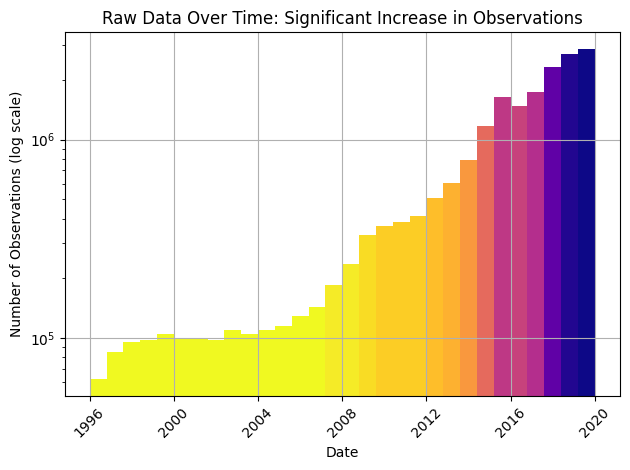

In [11]:
# Histogram parameters
counts, bins, patches = plt.hist(raw_option_data['date'], bins=30)

# Apply magma colormap
cmap = cm.get_cmap('plasma_r', len(patches))
normed = (counts - counts.min()) / (counts.max() - counts.min())
for patch, norm in zip(patches, normed):
    patch.set_facecolor(cmap(norm))

# Labels and aesthetics
plt.xlabel('Date')
plt.yscale('log')
plt.grid()
plt.ylabel('Number of Observations (log scale)')
plt.title('Raw Data Over Time: Significant Increase in Observations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Data Filtration

In order to minimize possible quoting errors, CJS filtered the raw options data through 3 levels of filters. The filters are applied to the trade-in (buy) side to make sure the portfolios are buying into reliable quotes. When positions are exited, if there is no quote in the filtered data, the raw data is searched. These filters are detailed in *Appendix B* of CJS. 

## Level 1 Filters

* **Identical Filter:** Retain only one instance of quotes with the same **option type**, **strike price**, **expiration date/maturity**, and **price**. 

* **Identical Except Price Filter:** There are a few sets of quotes with identical terms (**type**, **strike**, and **maturity**) but different prices. Keep the quote whose **T-bill-based implied volatility** is closest to that of its **moneyness neighbors**, and delete the others.  

* **Bid = 0 Filter:** Drop quotes with a **bid price** of zero, thereby avoiding low-valued options. Also, a zero bid may indicate censoring as negative bids cannot be recorded.

* **Volume = 0 Filter:** Drop quotes of zero for volumes. *Note: Appendix B of CJS does not explicitly detail this filter, but we include it here since it is included in *Table B.1. Filters* of CJS.*  



### Identical Filter

We drop records with identical **option type, strike, expiration date, and price**. In each such case, we eliminate all but one of the quotes. 

In [12]:
spx_filtered = f1.identical_filter(raw_option_data)
spx_filtered

,secid,date,open,close,cp_flag,exdate,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565.0,100.0,55.500,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540.0,100.0,76.000,0.874211
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560.0,100.0,58.250,0.908044
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475.0,100.0,146.000,0.768037
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425.0,100.0,188.875,0.697350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200.0,100.0,953.800,1.299996
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300.0,100.0,1051.150,1.330948
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400.0,100.0,1149.100,1.361900
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500.0,100.0,1247.000,1.392853


In [13]:
compare_filtered_data_to_orig(spx_filtered, raw_option_data, "Identical Filter")

| Identical Filter :
>> Records removed: 277,102 out of 19,213,898 (1.44%)
>> Filtered data shape: 18,936,796 rows // 16 columns


### Identical Except Price Filter

We drop records with **identical terms (type, strike, and maturity) but different prices**. Retained quotes are those whose T-bill-based implied volatility is closest to that of its moneyness neighbors, and delete the others. 

In [ ]:
spx_filtered_2 = f1.identical_but_price_filter(spx_filtered)
spx_filtered_2

In [ ]:
compare_filtered_data_to_orig(spx_filtered_2, spx_filtered, "Identical Except Price Filter:")

## Filter Options with Bid = 0 

We drop quotes with bids of zero (implying little to no market interest) and thereby avoiding low-valued options.

In [ ]:
spx_filtered_3 = f1.delete_zero_bid_filter(spx_filtered_2)
compare_filtered_data_to_orig(spx_filtered_3, spx_filtered_2, "Delete Zero Bid Filter")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of best_bid for optm_l1_id
axes[0].hist(spx_filtered_2['best_bid'], bins=30)
axes[0].set_xlabel('Best Bid')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Best Bid - Pre-filter')

# Plot distribution of best_bid for optm_l1_zbid
axes[1].hist(spx_filtered_3['best_bid'], bins=30, color='darkred')
axes[1].set_xlabel('Best Bid')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Best Bid - Post-filter')

plt.tight_layout()
plt.show()
print("Need some better plots here...")

## Filter Options with Vol = 0

Table B.1 of *CJS 2013* appears to signal the inclusion of a Volume = 0 filter, however, Appendix B does not describe this filter. We note that there are a significant number of quotes with zero volume in our dataset, and the application of this filter would dramatically skew the results from the original dataset (with 70% of remaining records dropped using this criterion). Given that Appendix B of *CJS 2013* did not describe this filter, we assume its inclusion in Table B.1 was an error.

In [ ]:
spx_filtered_4 = f1.delete_zero_volume_filter(spx_filtered_3)
compare_filtered_data_to_orig(spx_filtered_4, spx_filtered_3, "Delete Zero Volume Filter")

In [ ]:
spx_filtered_4 = spx_filtered_3.copy(deep=True)

In [ ]:
zero_vol_rows = spx_filtered_3[spx_filtered_3['volume'] == 0]
plt.hist(zero_vol_rows['date'], bins=30)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Options with Zero Volume')
plt.show()

In [ ]:
# save L1 filtered data
spx_l1_filtered = spx_filtered_4.copy(deep=True)
spx_l1_filtered.to_parquet(Path(DATA_DIR / f'L1_filtered_{DATE_RANGE}.parquet'), index=False)

---

## Level 2 Filters


* **Days to Maturity <7 or >180 Filter:** Drop options with fewer than seven or more than 180 calendar days to expiration. 


* **IV<5% or >100% Filter:** We remove all option quotes with implied volatilities lower than 5% or higher than 100%, computed using T-bill interest rates.

* **Moneyness <0.8 or >1.2 Filter:** We remove all option quotes with moneyness, the ratio of strike price to index price, below 0.8 or above 1.2. These options have little value beyond their intrinsic value and are also very thinly traded.

* **Implied Interest Rate <0 Filter:** When filtering outliers, we use T-bill interest rates to compute implied volatilities. T-bill interest rates are obtained from the Federal Reserve’s H.15 release. We assign a T-bill rate to each observation by assuming that we can use the next shortest rate if the time to expiration of the option is shorter than the shortest constant maturity rate.
Our goal is to obtain an interest rate that is as close as possible to the one faced by investors in the options market. It appears that the T-bill rates are
not the relevant ones when pricing these options. Specifically, when the T-bill rates are used, put and call implied volatilities do not line up very well; for
example, the T-bill rate tends to be too high for short maturity options, perhaps because no T-bill has maturity of less than a month. To address these
issues, we compute a put-call parity-implied interest rate. Since we believe that put-call parity holds reasonably well in this deep and liquid European options
market, we use the put-call parity-implied interest rate as our interest rate in the remainder of the paper and for further filters.
To construct this rate, we take all put-call pairs of a given maturity and impose put-call parity using the bid-ask midpoint as the price, and allowing the interest rate to adjust. We remove 89,563 pairs with a negative implied interest rate. We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and assign it to all quotes with that maturity. We are able to directly assign an implied interest rate to 93% of our sample in this way. We fill in the gaps by interpolating across maturities and if necessary, across days. Our implied interest rate is on average 54 bps above the T-bill rate

* **Unable to Compute IV Filter:** We remove quotes that imply negative time
value.


### Days to Maturity <7 or >180 Filter

We drop records with days to maturity less than 7 and greater than 180 days. The short maturity options tend to move erratically close to expiration and the long maturity options lack volume and open interest.

In [ ]:
spx_filtered_5 = f2.days_to_maturity_filter(spx_filtered_4, min_days=7, max_days=180) 
spx_filtered_5

In [ ]:
compare_filtered_data_to_orig(spx_filtered_5, spx_filtered_4, "Days to Maturity Filter")

### IV<5% or >100% Filter

We drop quotes with **implied volatilities lower than 5% or higher than 100%**, computed using T-bill interest rates of the nearest matching maturity. Such extreme IV values are likely a quotation problem or attached to low-value options.

In [ ]:
spx_filtered_6 = f2.iv_range_filter(spx_filtered_5, min_iv=0.05, max_iv=1.0)
spx_filtered_6


In [ ]:
compare_filtered_data_to_orig(spx_filtered_6, spx_filtered_5, "IV Range Filter")

### Moneyness <0.8 or >1.2 Filter

We remove all option quotes with moneyness ($\frac{K}{S}$) below 0.8 or above 1.2. These options have little value beyond their intrinsic value and are also very thinly traded.


In [ ]:
spx_filtered_7 = f2.moneyness_filter(spx_filtered_6, min_moneyness=0.8, max_moneyness=1.2)
spx_filtered_7

In [ ]:
compare_filtered_data_to_orig(spx_filtered_7, spx_filtered_6, "Moneyness Filter")

### Implied Interest Rate < 0 Filter

We remove all option quotes with negative implied interest rates, assuming put-call parity. 


In [ ]:
spx_filtered_8 = f2.implied_interest_rate_filter(spx_filtered_7)
spx_filtered_8


In [ ]:
compare_filtered_data_to_orig(spx_filtered_8, spx_filtered_7, "Negative Implied Interest Rate Filter")

### Unable to Compute IV Filter

We remove all option quotes that imply negative time value. 


In [ ]:
spx_filtered_9 = f2.unable_to_compute_iv_filter(spx_filtered_8)
spx_filtered_9


In [ ]:
compare_filtered_data_to_orig(spx_filtered_9, spx_filtered_8, "Unable to Compute IV Filter")

In [ ]:
# save L2 filtered data
spx_l2_filtered = spx_filtered_9.copy(deep=True)
spx_l2_filtered.to_parquet(Path(DATA_DIR / f'L2_filtered_{DATE_RANGE}.parquet'), index=False)

---

## Level 3 Filters


* **IV Filter:** The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. 

* **Put-Call Parity Filter:** The puts and calls need to be matched up based on trading date, expiry date, and option type.


### IV Filter

The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities.

In [ ]:
spx_filtered_10 = f3.IV_filter(spx_filtered_9, DATE_RANGE)
spx_filtered_10

In [ ]:
compare_filtered_data_to_orig(spx_filtered_10, spx_filtered_9, "IV Filter")

### Put-Call Parity Filter

The puts and calls need to be matched up based on trading date, expiry date, and option type. We then calculate the put-call parity implied interest rate, and filter out outliers based on the standard deviation of the relative distance between the interest rate implied by put-call parity, and the calculated daily median 3-month T-bill rate from the pulled data.

In [ ]:
spx_filtered_11 = f3.put_call_filter(spx_filtered_10, DATE_RANGE)
spx_filtered_11

In [ ]:
compare_filtered_data_to_orig(spx_filtered_11, spx_filtered_10, "Put-Call Parity Filter")

In [ ]:
# save L3 filtered data
spx_l3_filtered = spx_filtered_11.copy(deep=True)
spx_l3_filtered.to_parquet(Path(DATA_DIR / f'L3_filtered_{DATE_RANGE}.parquet'), index=False)

In [ ]:
# save final cleaned data to folder
spx_filtered_final = spx_filtered_11.copy(deep=True)

final_savefile = DATA_DIR / f'spx_filtered_final_{DATE_RANGE}.parquet'

try:
    spx_filtered_final.to_parquet(final_savefile, index=True)
    print(f">> Final filtered data saved to {final_savefile}")
except FileNotFoundError:
    print(f">> {DATA_DIR} does not exist. Creating directory...")
    os.makedirs(DATA_DIR, exist_ok=True)
    spx_filtered_final.to_parquet(final_savefile, index=True)
    print(f">> Final filtered data saved to {final_savefile}")

----